## Project1

### 1. Chosing of  label
First I need to specify the target this project want to predict. Home price index is a monthly renewed index but with data revisioned. The index itself is non-stationary, so the label should be the next month price return. However, the data can be updated during different periods, so my choice of the label is as follows:
With every update of the price index, I will do a forecast for its one month future return. Hence the label used for training should be recalculated if the index itself is revisioned.

In [1]:
from fredapi import Fred
import numpy as np 
import pandas as pd
from tqdm import tqdm 
import datetime 
import keras
from keras import backend as K
import tensorflow as tf
fred = Fred(api_key='71b1e448bbe0374c7eb29ddd9907b7aa')


In [2]:
data = fred.get_series_all_releases('CSUSHPINSA')
label = data.set_index(['realtime_start', 'date'])['value'].unstack().fillna(method = 'ffill')
label = pd.DataFrame(label.values[:, 1:]/label.values[:, :-1] - 1, index = label.index,  columns = label.columns[:-1])
check = label.stack().reset_index().groupby(['realtime_start'])['date'].last().reset_index()
assert (check['realtime_start'] < check['date']).sum() == 0
label = label.stack().groupby(level = ['realtime_start']).last()


### 2. Chosing of  features

From Fred DataBase I choosed several features as follows:

1. unemployment rate: demand  of people want to invest.
2. gdp: the nation's general wealth
3. long-short interest rate/30Year Mortgage Rate: general investing leverage. 
4. working-age population/total population: demand of investing the house. 
5. m2: overall liquidity of the currency
6. cpi/inflation: cost of general commodity products
7. median housing sales: expected willingness of investing in house
8. sp500：relatively high risk assets pricing level 

In [3]:
sym_dict = {
    "umemploy": "UNRATE",
    "gdp": 'GDP',
    "lsinterest":"T10Y2Y",
    "linterest":"MORTGAGE30US",
    "m2":"M2SL",
    "cpi": "CPIAUCSL",
    "median_sales": "MSPUS",
    "inflation": "T10YIE",
    "working_pop": "LFWA64TTUSM647S",
    "totpop": "POPTHM",
    "sp500": "SP500"    
            }

data_dict = {}

for i in tqdm(sym_dict.keys()):
    if i!=  "lsinterest" and i != "sp500" and i != "inflation":
        res = fred.get_series_all_releases(sym_dict[i])
    else:
        res = fred.get_series(sym_dict[i])
    data_dict[i] =  res 
    
    

type_dict = {
    "D": ["sp500", "lsinterest", "inflation"],
    "W": ["linterest"],
    "M": ['umemploy', "m2", 'cpi', "working_pop", "totpop"],
    "Q": ["gdp", "median_sales"]
}


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:15<00:00,  6.88s/it]


###  3. Preprocessing of feataures

1. Daily frequency data: SP500, longshort interest, inflation

    For every label, I choose previous 252 days data observations for each feature as the input of model. Especially for Sp500, I normalize the data by divide the last day price. Hence for each prediction, a matrix of dimension (252, 3) is inputed as the daily feature.

2. Other frequency data:
    
    For weekly, monthly, quarterly data, there are data revision at different time periods. The preprocess algo runs following logic:
    1. unpivot the data by the issued date(realtime_start) and report period(date)
    2. forfilling the nans
    3. for each timeindex in label, find the latest available X period data (X = 52, 24, 8 for weekly, monthly, quarterly data)
    4. for "gdp", "m2", 'cpi', 'median_sales', 'working_pop', 'tot_pop', those features are normalized by divide its last value.
    
    
    Following the same logic for daily frequency data, for each prediction, weekly/monthly/quarterly data is inputed as a matrix of (52, 1), (24, 5), (8,2) 
   
Additionaly, if the data inputed  has nans, it will be filled by mean of the corresponding feature. 
    





In [4]:
def processDailyFeatures(label, data_dict, name, D_lag):
    lst = []
    for i in label.index:
        arr = data_dict[name][:i].iloc[:-1].tail(D_lag).values
        arr[np.isnan(arr)] = np.nanmean(arr)
        if name == "sp500":
            last = arr[~np.isnan(arr)][-1]
            arr = arr/last
        lst.append(np.expand_dims(arr, axis = 1))
    
    lst = np.concatenate(lst, axis = 1).T
    lst = pd.DataFrame(lst, index = label.index)    
    return lst 


def processOtherFeatures(label, data_dict, name, lag):
    
    lst = []
    for i in label.index:
        dateprev = pd.to_datetime(i) - datetime.timedelta(days = 1)
        tmp = data_dict[name].set_index(['realtime_start', 'date'])['value'].unstack().fillna(method = 'ffill')
        arr = tmp[:dateprev].iloc[-1,:].dropna().values[-lag:]
        arr[np.isnan(arr)] = np.nanmean(arr)
        if name in ["gdp", "m2", 'cpi', 'median_sales', 'working_pop', 'tot_pop']:
            last = arr[~np.isnan(arr)][-1]
            arr = arr/last
        lst.append(np.expand_dims(arr, axis = 1))
    
    lst = np.concatenate(lst, axis = 1).T
    lst = pd.DataFrame(lst, index = label.index)    
    return lst 

def processFeatureArr(label, data_dict, type_dict):
    lst = []
    for name in type_dict.keys():
        res = []
        if name == "D":
            for j in tqdm(type_dict[name], desc = "processing" + name):
                tmp =  processDailyFeatures(label, data_dict, j, 252)
                tmp = np.expand_dims(tmp.values, axis = 2)
                res.append(tmp)
        
        else:
            lag_dict  = {'W':52,
                        'M':24,
                         'Q':8
                        }
            for j in tqdm(type_dict[name], desc = "processing" + name):
                tmp =  processOtherFeatures(label, data_dict, j, lag_dict[name])
                tmp = np.expand_dims(tmp.values, axis = 2)
                res.append(tmp)
        
        res = np.concatenate(res, axis = -1)
        lst.append(res)    
    return  lst 

###  4. Building Model

neural nets is chosen as the model, since nn has the capability for merging features with data of different frequency. For the sturcture of the model, four LSTM is used for merging four frequency (daily, weekly, monthly, quarterly) data. the four embeddings pass through a concat layer and a dense network is applied to fit the label. Further mse is used as the loss function and total data is splitted in train and val, which contains 90 samples and 17 samples respectively. A learning rate scheduler is applied to the fitting process, a decreasing factor would be applied to learning rate if val loss is not decreasing. 




In [5]:
def myModel():
    inputs = keras.Input(shape = [252, 3], name = "input_0")
    inputs2 = keras.Input(shape = [52, 1], name = "input_1")
    inputs3 = keras.Input(shape = [24, 5], name = "input_2")
    inputs4 = keras.Input(shape = [8, 2], name = "input_3")
        
    x1 = keras.layers.LSTM(8)(inputs)
    x2 = keras.layers.LSTM(8)(inputs2)
    x3 = keras.layers.LSTM(8)(inputs3)
    x4 = keras.layers.LSTM(8)(inputs4)

    z = K.concatenate([x1,x2,x3,x4])
    outputs = keras.layers.Dense(20,  activation = 'relu')(z)
    outputs = keras.layers.Dense(1)(outputs)
    outputs = keras.layers.BatchNormalization()(outputs)
    model = keras.Model(inputs = [inputs, inputs2, inputs3, inputs4], outputs = outputs)
    return model 

In [6]:
lst = processFeatureArr(label, data_dict, type_dict)
lst.append(label.values)

datasetX = tf.data.Dataset.from_tensor_slices((lst[0][:90], 
                                              lst[1][:90],
                                               lst[2][:90],
                                               lst[3][:90]
                                              ))
datasetY = tf.data.Dataset.from_tensor_slices(lst[4][:90])
traindata = tf.data.Dataset.zip((datasetX, datasetY)).batch(10)

datasetX = tf.data.Dataset.from_tensor_slices((lst[0][90:], 
                                              lst[1][90:],
                                               lst[2][90:],
                                               lst[3][90:]
                                              ))
datasetY = tf.data.Dataset.from_tensor_slices(lst[4][90:])
valdata = tf.data.Dataset.zip((datasetX, datasetY)).batch(10)


processingQ: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.14s/it]


In [13]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras import backend

model = myModel()

name = ''.join(str(datetime.datetime.now())[11:].split('.')[0].split(':'))
model_name = 'MYMODEL'+ name

nan_stop = TerminateOnNaN()
tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))
stop = EarlyStopping(monitor="val_loss", patience = 20, restore_best_weights = True)
learning_rate_decay = ReduceLROnPlateau(monitor="val_loss", 
                                        factor=0.75, patience = 3, min_delta= 1e-5)

model.compile(loss = "mse",
    optimizer = Adam(5e-4, )   )
model.fit(traindata.cache(),
          validation_data=valdata.cache(),
          callbacks = [stop, tensorboard, learning_rate_decay, nan_stop], 
          shuffle = False,
          epochs= 200)

Epoch 1/200
9/9 [==============================] - 7s 172ms/step - loss: 0.2089 - val_loss: 0.1083 - lr: 5.0000e-04
Epoch 2/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0934 - val_loss: 0.0513 - lr: 5.0000e-04
Epoch 3/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0401 - val_loss: 0.0201 - lr: 5.0000e-04
Epoch 4/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0200 - val_loss: 0.0085 - lr: 5.0000e-04
Epoch 5/200
9/9 [==============================] - 0s 37ms/step - loss: 0.0162 - val_loss: 0.0046 - lr: 5.0000e-04
Epoch 6/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0136 - val_loss: 0.0039 - lr: 5.0000e-04
Epoch 7/200
9/9 [==============================] - 0s 38ms/step - loss: 0.0106 - val_loss: 0.0050 - lr: 5.0000e-04
Epoch 8/200
9/9 [==============================] - 0s 39ms/step - loss: 0.0090 - val_loss: 0.0059 - lr: 5.0000e-04
Epoch 9/200
9/9 [==============================] - 0s 36ms/step - loss: 0.0079 

### 5. Comment  on  the results

Although the val loss is decreasing when epoch increases, the mse is still not good since the best rmse loss is around 1%. After checking the valdata, it can be founded that the result in 2023 Q3 has not been predicted very well by the model. Hence, the model may be imporved by several points as follow:

1. More features: some alternative data can be applied to forecast the housing price, such as sales data crawled from different housing website or renting agency. Sentimental analysis using NLP techniques can also be used as the sentimental scores for predicting the housing price. The problem of using economy data is the frequency of the data is low and sometimes signal is lagged, hence using higher frequency alternative data may help predicting the price index.

2. Different architecture of the model: timestep for different data can be varied, however optimization the structure can be very time-consuming. And tree model can be used as the model alternatively for caputring the cross information of different features. 

In [14]:
tot = pd.concat([label[90:], pd.DataFrame(model.predict(valdata), index = label.index[90:])], axis = 1)
tot.columns  = ['real', 'sig']
tot

2/2 [==============================] - 1s 21ms/step


,real,sig
realtime_start,,
2022-05-31,0.025536,-0.001061
2022-06-28,0.020779,0.014034
2022-07-26,0.014937,0.020205
2022-08-30,0.005901,0.041288
2022-09-27,-0.003310,0.052341
2022-10-25,-0.010686,-0.003190
2022-11-29,-0.010083,-0.025004
2022-12-27,-0.005316,-0.032403
2023-01-31,-0.005579,0.004940


## Project 3

In this section I will show a signal I am currently following and I thought the logic behind it was reasonable.

To have a brief background introduction, in Chinese Ashare Market, CSI300 Index contains the core assets of Chinese Company, just like the SP500. It is also a large cap index since it contains 300 largest market cap stocks in China. On the contrary, CSI1000 is a small cap index which contains bottom  1000 market cap from top 1800 stocks in Ashare market.

From Year 2023, the relationship between China and US is getting a lot worse and the whole world enconmy is getting tightened after the US raising the interest rate. Anyone investing in Chinese Market will think about the Fx risk ---- was it worth enough for risking holding a weak currency or not. A reasonable idea would be leaving the chinese market when US dollar outperfoms RMB, and vice versa.    

Hence, I guess when USD-CNH is going up, foreign invester would leave Chinese Market and causing a decrease in the coreasset Index CSI-300. Further, the selling power should not lasting for long duration, the market will repair after they leave the market, hence only a short time period of price dynamics is predictable. Last, A small-cap index can work as a benchmark to hedge the overall market systematic risk. We can just use the spread between CSI-300 and CSI-1000 to achieve this. 

CSI300 and CSI1000 both have corresponding futures, but in the following code I just assumed the index itself can be long or short for simiplicity. And since I just want to show the trading idea, certain parameters are chosen subjectively and not be tunned.




In [1]:
import yfinance as yf
import pandas as pd 
import numpy as np 

#get two index(large cap and small cap index) future return
#forecast_start indicates the no. of minbar  to count for start, same for forecast_end,
#since this is 1-minibar data, forecast_start and forecast end ranges from 0-239
def getForecastLabel(forecast_start, forecast_end):    
    price = pd.read_csv('./price.csv',index_col = 0)

    large_cap = price[price['StockID'] == 'SH000300'].copy()
    large_cap.loc[:, 'no_bar'] = np.arange(len(large_cap))%240
    large_cap.index = pd.to_datetime(large_cap.index)

    small_cap = price[price['StockID'] == 'SH000852'].copy()
    small_cap.loc[:, 'no_bar'] = np.arange(len(small_cap))%240
    small_cap.index = pd.to_datetime(small_cap.index)

    
    price_in = large_cap[large_cap['no_bar'] == forecast_start]['open']
    price_out = large_cap[large_cap['no_bar'] == forecast_end]['close']
    price_in.index = price_in.index.date
    price_out.index = price_out.index.date
    label = price_out/price_in - 1
    label.index = pd.to_datetime(label.index)

    price_in = small_cap[small_cap['no_bar'] == forecast_start]['open']
    price_out = small_cap[small_cap['no_bar'] == forecast_end]['close']
    price_in.index = price_in.index.date
    price_out.index = price_out.index.date
    label2 = price_out/price_in - 1
    label2.index = pd.to_datetime(label2.index)
    label = pd.concat([label, label2], axis = 1)
    label.columns  = ['label_largecap', 'label_smallcap']
    return label

#get the signal -- which  is the return of the fx rate
#timeperiod is the range of the fx periods used, isPrev inidicates whether  the time  is  previous date or not 
def getSigPeriod(fx, timeperiod, isPrev):
    sig_start, sig_end = timeperiod
    isPrev_start, isPrev_end = isPrev
    
    time_search = pd.DataFrame(label.index, index = pd.to_datetime(label.index), columns = ['prev_date']).shift(1).dropna()
    
    if isPrev_start:
        time_search['sig_start'] =  pd.to_datetime([str(i)[:10] + " " + sig_start for i in time_search['prev_date']])
    else:
        time_search['sig_start'] =  pd.to_datetime([str(i)[:10] + " " + sig_start for i in time_search.index])
    
    if isPrev_end:
        time_search['sig_end'] = pd.to_datetime([str(i)[:10] + " " + sig_end for i in time_search['prev_date']])
    else:
        time_search['sig_end'] = pd.to_datetime([str(i)[:10] + " " + sig_end for i in time_search.index])
    
    
    
    sigp = [fx.loc[i:, 'Open'].values[0] for i in time_search['sig_start']]
    sign = [fx.loc[i:, 'Open'].values[0] for i in time_search['sig_end']]
    sig = np.array(sign)/np.array(sigp) - 1
    sig = pd.Series(sig, index = pd.to_datetime([str(i)[:10] for i in time_search['sig_end']]))
    res = pd.concat([sig, label], axis = 1).dropna()
    res.columns= ['sig', 'label_largecap', 'label_smallcap']
    return res 

In [4]:
#fetch fx rates
symbol = "usdcnh=x"
ticker = yf.Ticker(symbol)
fx = ticker.history(start = '2021-12-31',
                       end = '2023-09-28',
                      interval='1h',
                      actions=True,
                      auto_adjust=True)
fx.index = pd.Series(fx.index).dt.tz_convert('Asia/Shanghai')
fx.index = pd.Series(fx.index).dt.tz_localize(None)

In [5]:
#hold the spread for 10minutes, and closed the position intraday
#the fx period I looked is 4am to 9am in CST, since this is the time when US market shutdown and the Chinsese Market Not Opened.


forecast = 0, 10
label = getForecastLabel(*forecast)
tot = getSigPeriod(fx, ("04:00:00", '09:00:00'), (False, False))
tot['2023-01-01':].corr()

#We can see especially from 2023-01-01, the correlation between fxrates and two indices diverge

,sig,label_largecap,label_smallcap
sig,1.000000,-0.057213,0.063228
label_largecap,-0.057213,1.000000,0.507414
label_smallcap,0.063228,0.507414,1.000000


<Axes: >

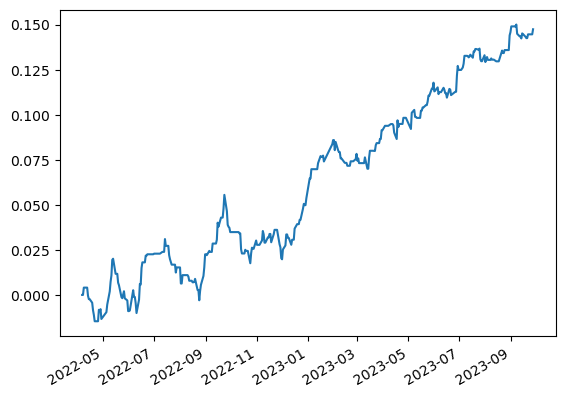

In [6]:
#using zscore, the threshold is set to be 0.5

window  = 60
zscore = (tot['sig'] -  tot['sig'].rolling(window = window).mean())/tot['sig'].rolling(window = window).std()
spread = tot['label_largecap'] - tot['label_smallcap']
strats =  pd.concat([zscore, spread], axis = 1).dropna()
strats.columns =  ['zscore',  'spread']
strats['pos'] = 0
strats.loc[strats['zscore']<= -0.5, 'pos' ]  = 1
strats.loc[strats['zscore']>= 0.5, 'pos'] = -1
strats[['spread', 'pos']].prod(axis = 1).cumsum().plot()